In [29]:
import sys
sys.path.insert(0, '/das/work/p17/p17983/')

In [30]:
%matplotlib nbagg
import numpy as np
import json
import os
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm

Set up the filters.  "numstds" is the number of standard deviations to take from the median.

Plot some diagnostics

In [31]:
def get_XAS(scan_name, DIR, DIR_json, numstds, minIzero):
    #numstds = 2
    #minIzero = 0.015

    json_file = DIR_json + scan_name + "_scan_info.json"
    print (json_file)

    with open(json_file) as file:
        data = json.load(file)
    numFiles = len(data['scan_files'])

    print ("Processing",numFiles,"files")

    DataFluo_pump_norm_total = np.empty(0)
    DataFluo_unpump_norm_total = np.empty(0)
    err_DataFluo_pump_total = np.empty(0)
    err_DataFluo_unpump_total = np.empty(0)

    IzeroFEL_pump_original_total = np.empty(0)
    IzeroFEL_pump_total = np.empty(0)
    IzeroFEL_unpump_original_total = np.empty(0)
    IzeroFEL_unpump_total = np.empty(0)

    DataFluo_pump_original_total = np.empty(0)
    DataFluo_pump_total = np.empty(0)
    DataFluo_unpump_original_total = np.empty(0)
    DataFluo_unpump_total = np.empty(0)

    Energy_eV = np.empty(0)
    iZero = np.empty(0)

    for i in range(0,numFiles):
    #for i in range(0,1):
        filename = str(data['scan_files'][i][0])
        filename = DIR + os.path.basename(filename)
        exists = os.path.isfile(filename)
        if not exists:
            print("No such file")
        elif exists: #Do we need this 39?
#             print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][0])))
            (DataFluo_pump, DataFluo_unpump, IzeroFEL_pump, IzeroFEL_unpump, Energy, _, _, _) = \
                load_PumpProbe_events(filename, channel_energy)

            IzeroFEL_pump_original = IzeroFEL_pump.copy()
            IzeroFEL_unpump_original = IzeroFEL_unpump.copy()

            IzeroFEL_pump_original_total = np.append(IzeroFEL_pump_original_total, IzeroFEL_pump_original)
            IzeroFEL_unpump_original_total = np.append(IzeroFEL_unpump_original_total, IzeroFEL_unpump_original)

            DataFluo_pump_original_total = np.append(DataFluo_pump_original_total, DataFluo_pump)
            DataFluo_unpump_original_total = np.append(DataFluo_unpump_original_total, DataFluo_unpump)

            IzeroMedian = np.median(np.concatenate([IzeroFEL_pump, IzeroFEL_unpump]))
            IzeroSTD = np.std(np.concatenate([IzeroFEL_pump, IzeroFEL_unpump]))

            conditionPumpMax = IzeroFEL_pump < IzeroMedian+numstds*IzeroSTD
            conditionPumpMin = IzeroFEL_pump > IzeroMedian-numstds*IzeroSTD
            conditionPumpLow = IzeroFEL_pump > minIzero

            conditionUnPumpMax = IzeroFEL_unpump < IzeroMedian+numstds*IzeroSTD
            conditionUnPumpMin = IzeroFEL_unpump > IzeroMedian-numstds*IzeroSTD
            conditionUnPumpLow = IzeroFEL_unpump > minIzero

            condIzeroPump = conditionPumpMax & conditionPumpMin & conditionPumpLow
            condIzeroUnPump = conditionUnPumpMax & conditionUnPumpMin & conditionUnPumpLow

            IzeroFEL_pump = IzeroFEL_pump[condIzeroPump]
            IzeroFEL_unpump = IzeroFEL_unpump[condIzeroUnPump]

            IzeroFEL_pump_total = np.append(IzeroFEL_pump_total, IzeroFEL_pump)
            IzeroFEL_unpump_total = np.append(IzeroFEL_unpump_total, IzeroFEL_unpump)

            DataFluo_pump = DataFluo_pump[condIzeroPump]
            DataFluo_unpump = DataFluo_unpump[condIzeroUnPump]

#             print(DataFluo_pump.shape)

            DataFluo_pump_total = np.append(DataFluo_pump_total, DataFluo_pump)
            DataFluo_unpump_total = np.append(DataFluo_unpump_total, DataFluo_unpump)

            DataFluo_pump_norm = DataFluo_pump/IzeroFEL_pump
            DataFluo_unpump_norm = DataFluo_unpump/IzeroFEL_unpump

            DataFluo_pump_norm_total = np.append(DataFluo_pump_norm_total, DataFluo_pump_norm.mean())
            DataFluo_unpump_norm_total = np.append(DataFluo_unpump_norm_total, DataFluo_unpump_norm.mean())
            err_DataFluo_pump_total = np.append(err_DataFluo_pump_total, DataFluo_pump_norm.std()/np.sqrt(DataFluo_pump_norm.size))
            err_DataFluo_unpump_total = np.append(err_DataFluo_unpump_total, DataFluo_unpump_norm.std()/np.sqrt(DataFluo_unpump_norm.size))

            Energy = [x for x in Energy if (np.abs(x) > 0)]
            Energy_eV = np.append(Energy_eV, np.mean(Energy))
            iZero = [x for x in iZero if (np.abs(x) > 0)]
            iZero = np.append(iZero, np.mean(IzeroFEL_pump_total))
            
#     print("The original number of pumped and unpumped shots is:")
#     print(IzeroFEL_pump_original_total.shape, IzeroFEL_unpump_original_total.shape)
#     print("The filtered number of pumped and unpumped shots is:")
#     print(IzeroFEL_pump_total.shape, IzeroFEL_unpump_total.shape)
    plt.figure()
    _, bins, _ = plt.hist(IzeroFEL_pump_original_total, 100, label = 'unfiltered')
    _ = plt.hist(IzeroFEL_pump_total, bins, rwidth = .5, label = 'filtered')
    plt.title('Izero, pumped')
    plt.legend()

    plt.figure()
    _, bins, _ = plt.hist(IzeroFEL_unpump_original_total, 100, label = 'unfiltered')
    _ = plt.hist(IzeroFEL_unpump_total, bins, rwidth = .5, label = 'filtered')
    plt.title('Izero, unpumped')
    plt.legend()
    
    plt.figure()
    plt.scatter(IzeroFEL_pump_original_total, DataFluo_pump_original_total)
    plt.scatter(IzeroFEL_pump_total, DataFluo_pump_total)
    plt.title('Izero, pumped')
    plt.xlabel('I0')
    plt.ylabel('Absorption')
    
#     print(Energy_eV.shape)
#     print(iZero.shape)
#     print(DataFluo_pump_norm_total.shape)
#     print(DataFluo_unpump_norm_total.shape)

    Energy_eV = Energy_eV[1:]
    DataFluo_pump_norm_total = DataFluo_pump_norm_total[1:]
    DataFluo_unpump_norm_total = DataFluo_unpump_norm_total[1:]
    iZero =iZero[1:]
    
    plt.figure()
    plt.plot(np.array(Energy_eV), DataFluo_pump_norm_total,label='Pumped')
    plt.plot(np.array(Energy_eV), DataFluo_unpump_norm_total,label='UnPumped')
    plt.plot(np.array(Energy_eV), np.array(iZero)*100,label="I_zero_Arb")
    plt.xlabel('energy (eV)')
    plt.ylabel('absorption')
    plt.title('XAS_'+ scan_name)
    plt.legend()


    return iZero, Energy_eV, DataFluo_unpump_norm_total, DataFluo_pump_norm_total
        

/sf/alvra/data/p17983/res/scan_info/RuBpy3_monoscan_010_scan_info.json
Processing 55 files


<IPython.core.display.Javascript object>


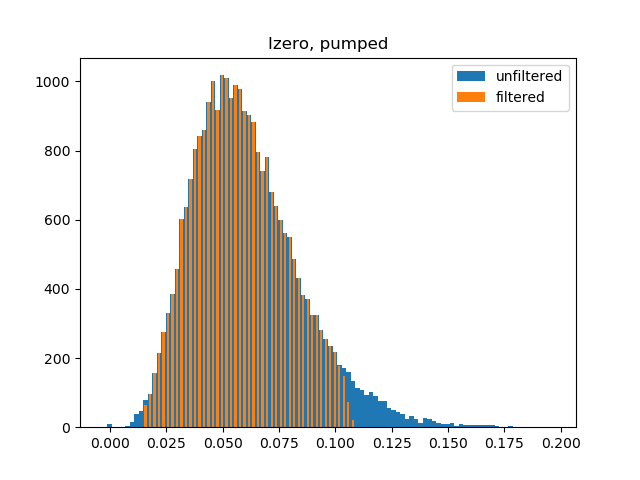

<IPython.core.display.Javascript object>


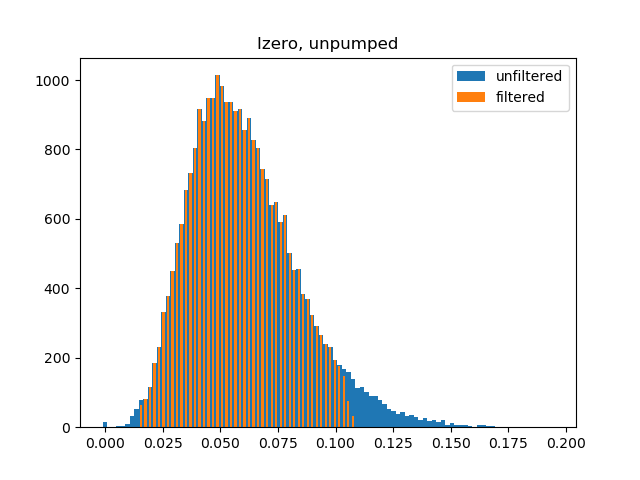

<IPython.core.display.Javascript object>


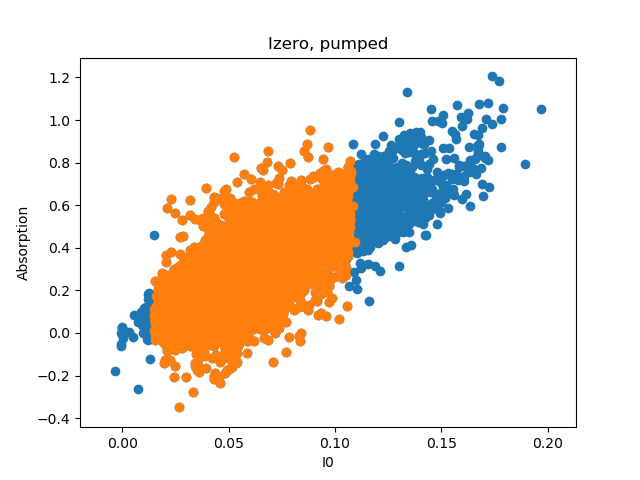

<IPython.core.display.Javascript object>


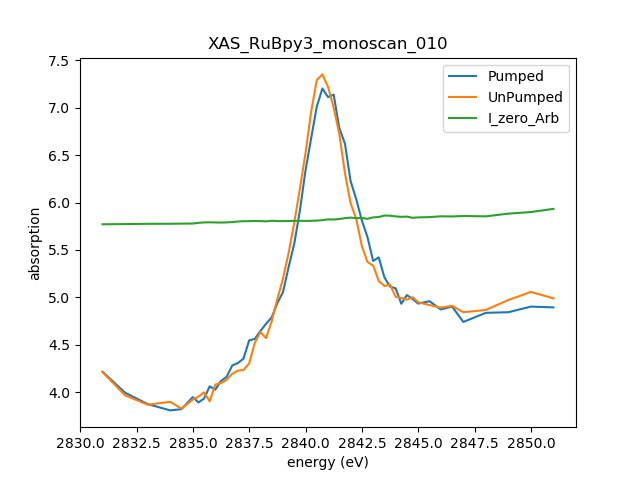

/sf/alvra/data/p17983/res/scan_info/RuBpy3_monoscan_011_scan_info.json
Processing 55 files


<IPython.core.display.Javascript object>


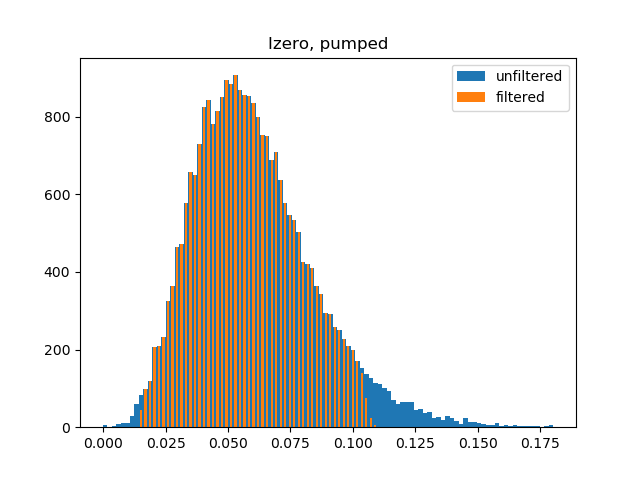

<IPython.core.display.Javascript object>


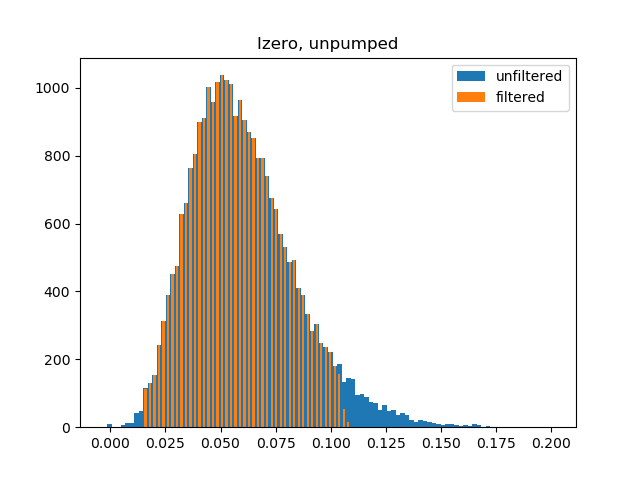

<IPython.core.display.Javascript object>


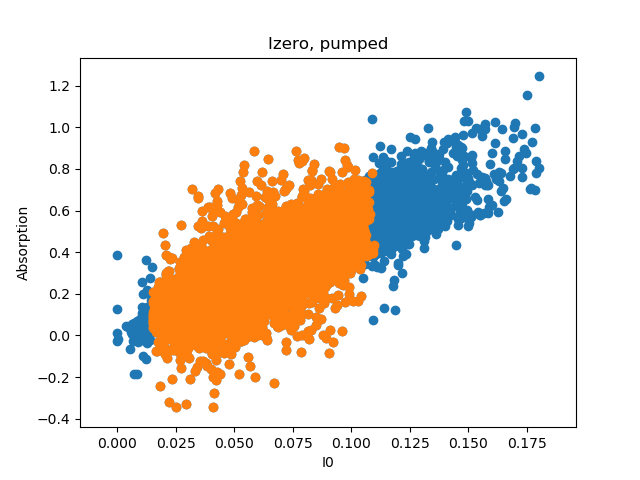

<IPython.core.display.Javascript object>


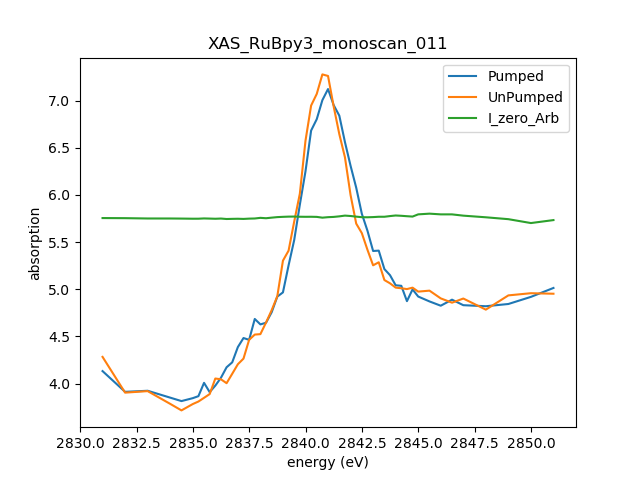

/sf/alvra/data/p17983/res/scan_info/RuBpy3_monoscan_014_scan_info.json
Processing 55 files


<IPython.core.display.Javascript object>


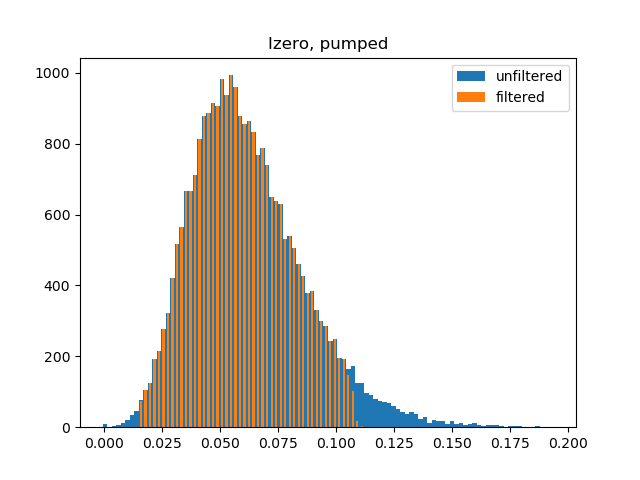

<IPython.core.display.Javascript object>


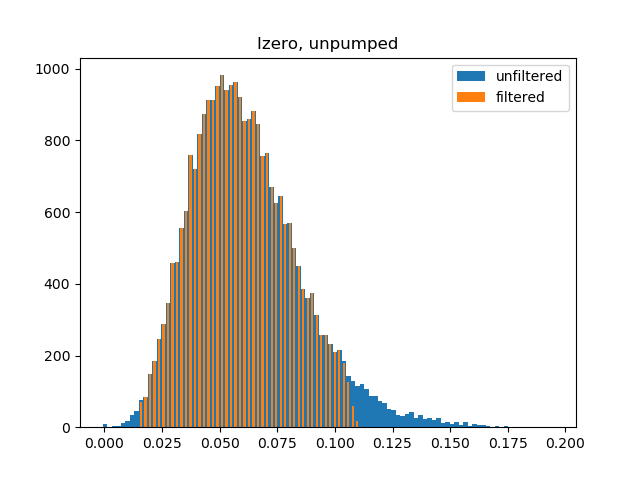

<IPython.core.display.Javascript object>


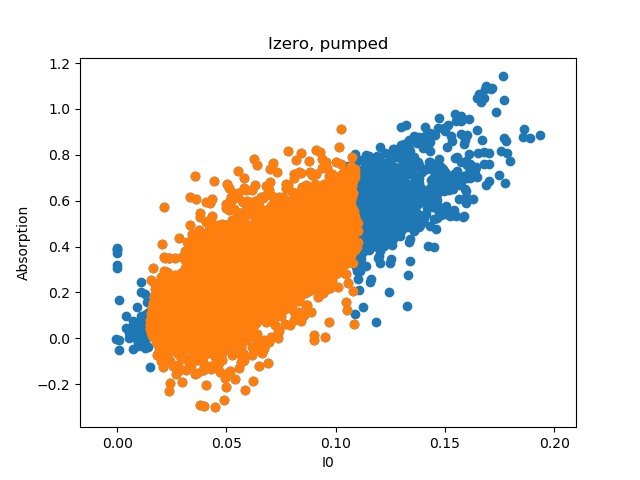

<IPython.core.display.Javascript object>


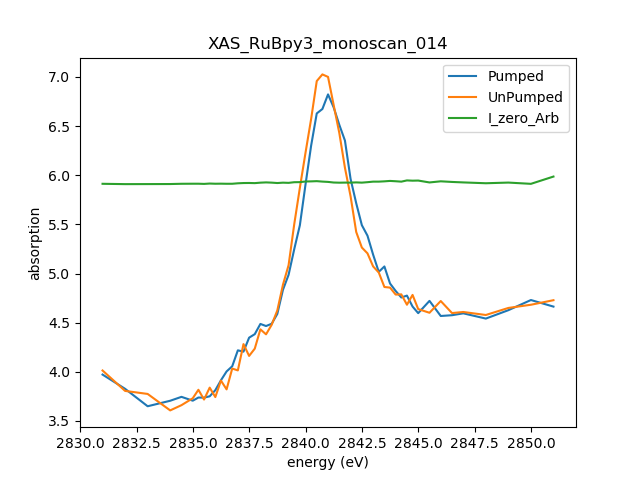

/sf/alvra/data/p17983/res/scan_info/RuBpy3_monoscan_012_scan_info.json
Processing 55 files


<IPython.core.display.Javascript object>


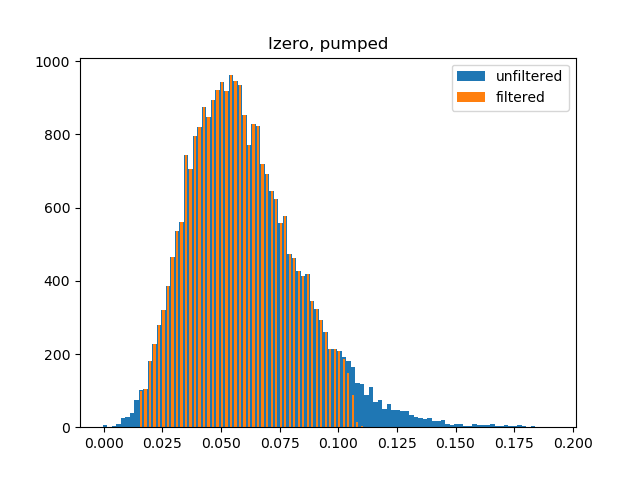

<IPython.core.display.Javascript object>


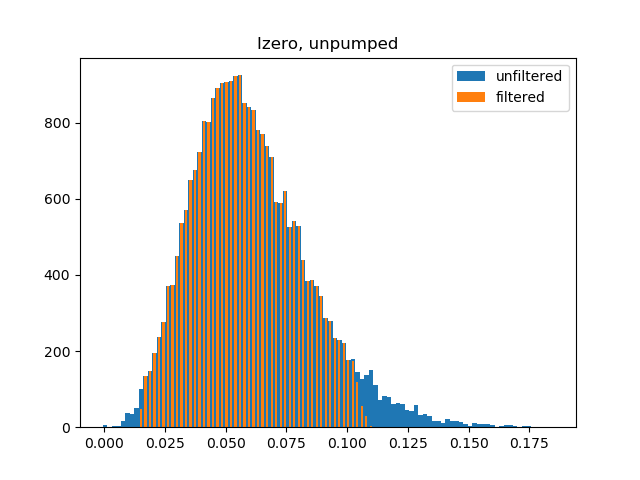

<IPython.core.display.Javascript object>


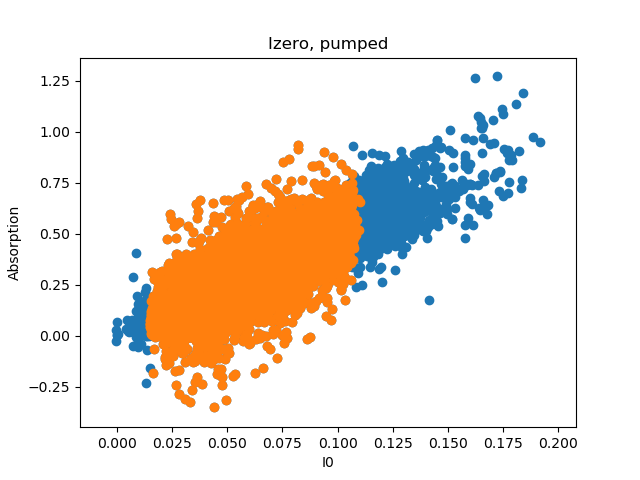

<IPython.core.display.Javascript object>


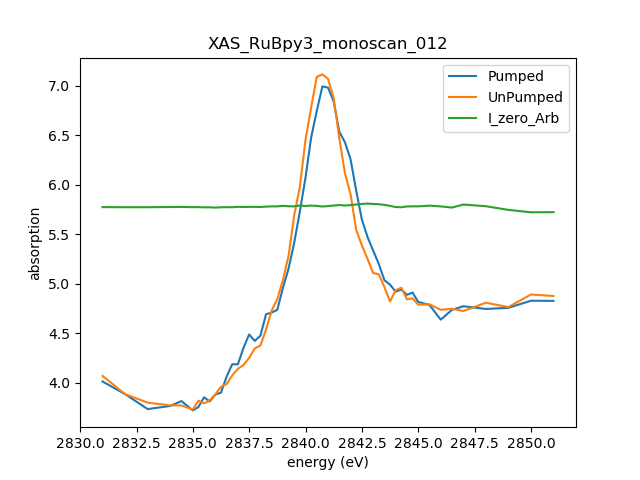

[2850.99574208 2849.9952403  2848.99583799 2847.99554947 2846.99597848
 2846.49624271 2845.99566756 2845.49625394 2844.99546782 2844.74543074
 2844.49651749 2844.24587888 2843.99546639 2843.74634789 2843.49571634
 2843.24554459 2842.99578448 2842.74562849 2842.49563784 2842.24552194
 2841.99531525 2841.74589563 2841.49563767 2841.24539402 2840.99466391
 2840.74537933 2840.49532714 2840.24566432 2839.99517021 2839.7450346
 2839.49559405 2839.24564501 2838.99554594 2838.74536263 2838.49530752
 2838.24478669 2837.99549607 2837.7448543  2837.49571871 2837.24496513
 2836.99529988 2836.74519021 2836.49580955 2836.24570763 2835.99508902
 2835.74478533 2835.49481543 2835.24514664 2834.99458266 2834.49320608
 2833.99394996 2832.9922601  2831.99196657 2830.99237252]
(54,)
(54,)


In [34]:
ploton = True


numstds = 2
minIzero = 0.015

scan_name_01 = "RuBpy3_monoscan_010"
scan_name_02 = "RuBpy3_monoscan_011"
scan_name_03 = "RuBpy3_monoscan_014"

scan_name_04 = "RuBpy3_monoscan_012"

# scan_name = "Ru_foil_monoscan_003"

# sf/alvra/data/p17983/raw/scan_data/Ru_foil_monoscan_001/
DIR_01 = "/sf/alvra/data/p17983/raw/scan_data/" + scan_name_01 + "/"
DIR_02 = "/sf/alvra/data/p17983/raw/scan_data/" + scan_name_02 + "/"
DIR_03 = "/sf/alvra/data/p17983/raw/scan_data/" + scan_name_03 + "/"
DIR_04 = "/sf/alvra/data/p17983/raw/scan_data/" + scan_name_04 + "/"
# DIR_json = "/das/work/p17/p17983/Example_data/res/scan_info/"
DIR_json = "/sf/alvra/data/p17983/res/scan_info/"

(iZero_01,Energy_eV_01,DataFluo_unpump_norm_total_01, DataFluo_pump_norm_total_01) = get_XAS(scan_name_01, DIR_01, DIR_json, numstds, minIzero)
(iZero_02,Energy_eV_02,DataFluo_unpump_norm_total_02, DataFluo_pump_norm_total_02) = get_XAS(scan_name_02, DIR_02, DIR_json, numstds, minIzero)
(iZero_03,Energy_eV_03,DataFluo_unpump_norm_total_03, DataFluo_pump_norm_total_03) = get_XAS(scan_name_03, DIR_03, DIR_json, numstds, minIzero)
(iZero_04,Energy_eV_04,DataFluo_unpump_norm_total_04, DataFluo_pump_norm_total_04) = get_XAS(scan_name_04, DIR_04, DIR_json, numstds, minIzero)
d1 = (DataFluo_pump_norm_total_01 - DataFluo_unpump_norm_total_01)#/DataFluo_unpump_norm_total_01
d2 = (DataFluo_pump_norm_total_02 - DataFluo_unpump_norm_total_02)#/DataFluo_unpump_norm_total_02
d3 = (DataFluo_pump_norm_total_03 - DataFluo_unpump_norm_total_03)#/DataFluo_unpump_norm_total_03

#d4 = (DataFluo_pump_norm_total_04 - DataFluo_unpump_norm_total_04)

ave_p = DataFluo_pump_norm_total_01 + DataFluo_pump_norm_total_02 + DataFluo_pump_norm_total_03
ave_u = DataFluo_unpump_norm_total_01 + DataFluo_unpump_norm_total_02 + DataFluo_unpump_norm_total_03
    
Energy_ave = 1/3*(Energy_eV_01 + Energy_eV_02 + Energy_eV_03)
    
    
offset_min = 0.1
ave_p_bg = ave_p - min(ave_u) + offset_min
ave_u_bg = ave_u - min(ave_u) + offset_min

Fluo_p_04_bg = DataFluo_pump_norm_total_04 - min(DataFluo_unpump_norm_total_04) + offset_min
Fluo_u_04_bg = DataFluo_unpump_norm_total_04 - min(DataFluo_unpump_norm_total_04) + offset_min


dave = (ave_p_bg - ave_u_bg)/ave_u_bg
d4 = (Fluo_p_04_bg - Fluo_u_04_bg)/Fluo_u_04_bg


<IPython.core.display.Javascript object>


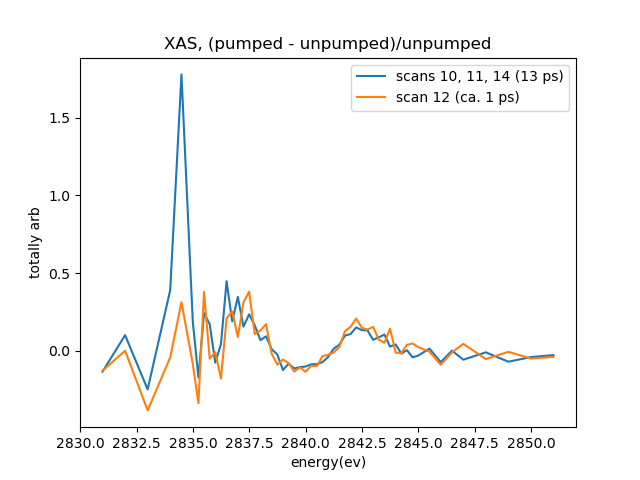

<IPython.core.display.Javascript object>


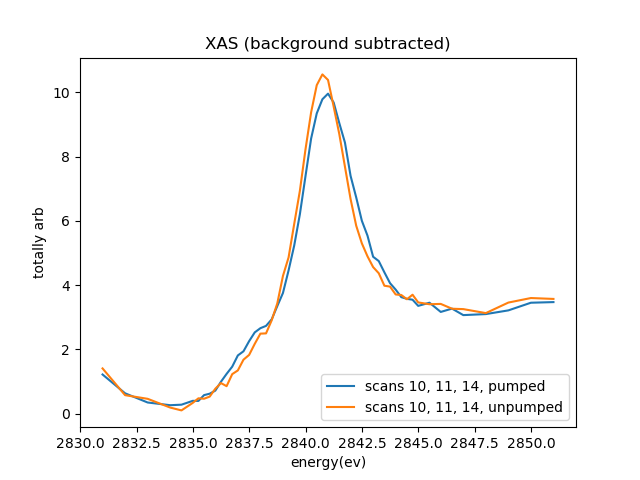

<IPython.core.display.Javascript object>


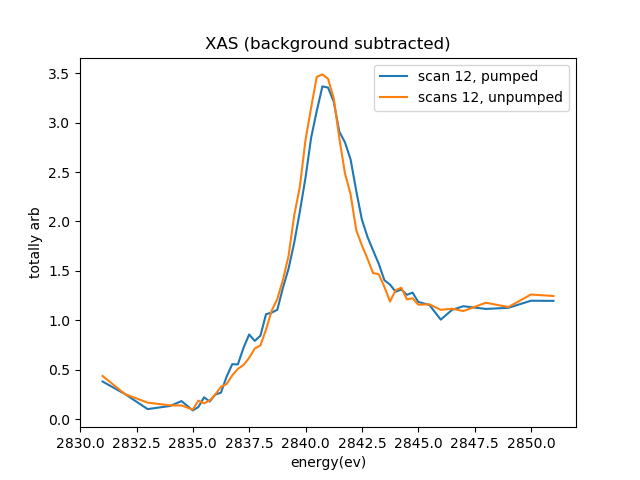

Text(0.5, 0, 'energy(ev)')

In [5]:
plt.figure()
plt.plot(np.array(Energy_ave), dave, label='scans 10, 11, 14 (13 ps)') 
plt.plot(np.array(Energy_eV_04), d4, label='scan 12 (ca. 1 ps)')
plt.legend()
plt.title('XAS, (pumped - unpumped)/unpumped')
plt.ylabel('totally arb')
plt.xlabel('energy(ev)')

plt.figure()
plt.plot(np.array(Energy_ave), ave_p_bg, label='scans 10, 11, 14, pumped') 
plt.plot(np.array(Energy_ave), ave_u_bg, label='scans 10, 11, 14, unpumped') 
plt.legend()
plt.title('XAS (background subtracted)')
plt.ylabel('totally arb')
plt.xlabel('energy(ev)')

plt.figure()
plt.plot(np.array(Energy_eV_04), Fluo_p_04_bg, label='scan 12, pumped') 
plt.plot(np.array(Energy_eV_04), Fluo_u_04_bg, label='scans 12, unpumped') 
plt.legend()
plt.title('XAS (background subtracted)')
plt.ylabel('totally arb')
plt.xlabel('energy(ev)')

In [6]:
#get rid of zero offset before comparing spectra

offset_min = 0.1
DataFluo_pump_norm_total_01 = DataFluo_pump_norm_total_01-min(DataFluo_unpump_norm_total_01)+offset_min
DataFluo_unpump_norm_total_01 = DataFluo_unpump_norm_total_01-min(DataFluo_unpump_norm_total_01)+offset_min

DataFluo_pump_norm_total_02 = DataFluo_pump_norm_total_02-min(DataFluo_unpump_norm_total_02)+offset_min
DataFluo_unpump_norm_total_02 = DataFluo_unpump_norm_total_02-min(DataFluo_unpump_norm_total_02)+offset_min

DataFluo_pump_norm_total_03 = DataFluo_pump_norm_total_03-min(DataFluo_unpump_norm_total_03)+offset_min
DataFluo_unpump_norm_total_03 = DataFluo_unpump_norm_total_03-min(DataFluo_unpump_norm_total_03)+offset_min

<IPython.core.display.Javascript object>


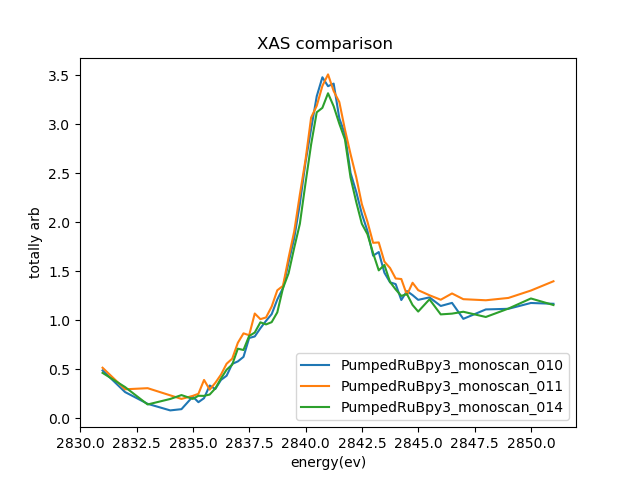

Text(0.5, 0, 'energy(ev)')

In [7]:
scaling = 1

plt.figure()
plt.plot(np.array(Energy_eV_01), DataFluo_pump_norm_total_01, label='Pumped'+scan_name_01)
#plt.plot(np.array(Energy_eV_01), DataFluo_unpump_norm_total_01, label='UnPumped'+scan_name_01)
plt.plot(np.array(Energy_eV_02), DataFluo_pump_norm_total_02*scaling, label='Pumped'+scan_name_02) 
#plt.plot(np.array(Energy_eV_02), DataFluo_unpump_norm_total_02*scaling, label='UnPumped'+scan_name_02)
plt.plot(np.array(Energy_eV_03), DataFluo_pump_norm_total_03*scaling, label='Pumped'+scan_name_03) 
#plt.plot(np.array(Energy_eV_03), DataFluo_unpump_norm_total_03*scaling, label='UnPumped'+scan_name_03)
plt.legend()
plt.title('XAS comparison ')
plt.ylabel('totally arb')
plt.xlabel('energy(ev)')

/sf/alvra/anaconda/dev/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


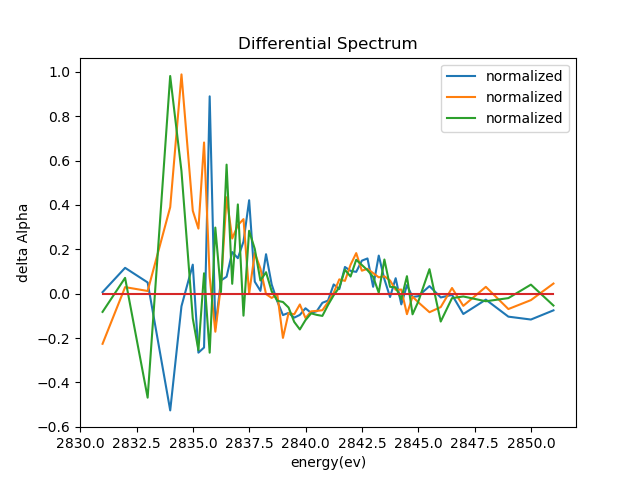

In [28]:
differential_01 = (DataFluo_pump_norm_total_01-DataFluo_unpump_norm_total_01)#/DataFluo_unpump_norm_total_01
differential_02 = (DataFluo_pump_norm_total_02-DataFluo_unpump_norm_total_02)#/DataFluo_unpump_norm_total_01
differential_03 = (DataFluo_pump_norm_total_03-DataFluo_unpump_norm_total_03)#/DataFluo_unpump_norm_total_01
plt.figure()
#plt.plot(np.array(Energy_eV_01), differential, label='not normalized')
plt.plot(np.array(Energy_eV_01), differential_01/DataFluo_unpump_norm_total_01, label='normalized')
plt.plot(np.array(Energy_eV_02), differential_02/DataFluo_unpump_norm_total_02, label='normalized')
plt.plot(np.array(Energy_eV_03), differential_03/DataFluo_unpump_norm_total_03, label='normalized')


zeroLine = np.zeros(np.array(Energy_eV_01).shape)
plt.plot(np.array(Energy_eV_01),zeroLine)

plt.xlabel('energy(ev)')
plt.title('Differential Spectrum')# '+scan_name_01)
plt.ylabel('delta Alpha')
plt.legend()

# plt.xlim([2837.5,2850])
# plt.ylim([-.5,.5])

/sf/alvra/anaconda/dev/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


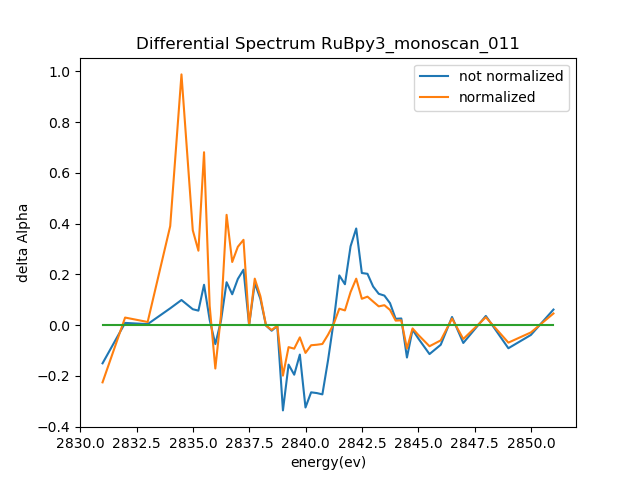

/sf/alvra/anaconda/dev/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


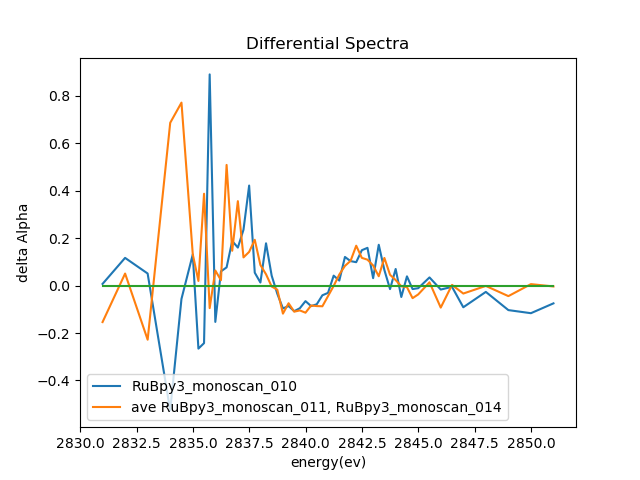

In [27]:
differential = (DataFluo_pump_norm_total_02-DataFluo_unpump_norm_total_02)
plt.figure()
plt.plot(np.array(Energy_eV_02), differential, label='not normalized')
plt.plot(np.array(Energy_eV_02), differential/DataFluo_unpump_norm_total_02, label='normalized')
zeroLine = np.zeros(np.array(Energy_eV_02).shape)
plt.plot(np.array(Energy_eV_02),zeroLine)
plt.xlabel('energy(ev)')
plt.title('Differential Spectrum '+scan_name_02)
plt.ylabel('delta Alpha')
plt.legend()

# plt.ylim([-.5,.5])


d1 = (DataFluo_pump_norm_total_01-DataFluo_unpump_norm_total_01)/DataFluo_unpump_norm_total_01
d2 = (DataFluo_pump_norm_total_02-DataFluo_unpump_norm_total_02)/DataFluo_unpump_norm_total_02
d3 = (DataFluo_pump_norm_total_03-DataFluo_unpump_norm_total_03)/DataFluo_unpump_norm_total_03

d23 = 0.5*(d2 + d3)

plt.figure()
plt.plot(np.array(Energy_eV_01), d1, label=scan_name_01)
plt.plot(np.array(Energy_eV_02), d23, label='ave ' + scan_name_02 + ', ' + scan_name_03)
zeroLine = np.zeros(np.array(Energy_eV_01).shape)
plt.plot(np.array(Energy_eV_01),zeroLine)
plt.xlabel('energy(ev)')
plt.title('Differential Spectra')
plt.ylabel('delta Alpha')
plt.legend()